In [1]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from scipy.linalg import sqrtm

import pickle 
import matplotlib as mpl


Unpacking the data

In [3]:
with open('data/sampled_filters_train.pkl', 'rb') as f:
    data_train = pickle.load(f)
with open('data/sampled_filters_val.pkl', 'rb') as f:
    data_val = pickle.load(f)


In [4]:
##########################################################################################
# Data
##########################################################################################

def get_data(data):
    #in data
    #wavelength (4000000, 149)
    #spectra (4000000, 149)
    #X (4000000, 37)
    #y (4000000, 4)
    #z (4000000, 1)
    #zmin (float)
    #zmax (float)
    #filter_names (string list), len = 37
    df_X = pd.DataFrame(data['X'])
    outlier_columns = df_X.columns[df_X.gt(58.8).any(axis = 0)]
    df_X = df_X.drop(outlier_columns, axis = 1)
    X = df_X.to_numpy()
    y = pd.DataFrame(data['y'])
    z = pd.DataFrame(data['z'])
    wavelengths = data['wavelengths']
    spectra = data['spectra']
    
    #get normalized X
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(df_X)
    #get X scaled between [-1, 1]
    min_val = X.min()
    max_val = X.max()
    X_scaled = (X - min_val) / (max_val - min_val)
    y_normalized = scaler.fit_transform(y)

    names=data['filter_names']
    filter_wls = [int(name[1:-1].rstrip('W')) for name in names]
    filter_wls = [element for i, element in enumerate(filter_wls) if i not in outlier_columns]
    return filter_wls, wavelengths, spectra, X, X_normalized, X_scaled, y, y_normalized, z

def rescale_data(X_normalized, X_min, X_max):
    X_rescaled = X_normalized * (X_max - X_min) + X_min
    return X_rescaled

filter_wls, wavelengths, spectra, X, X_normalized, X_scaled,  y, y_normalized, z = get_data(data_train)

_, _, _, vX, vX_normalized, vX_scaled,  vy, vy_normalized, _ = get_data(data_val)



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


define network

In [ ]:
class SinPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = time / (10000**(2 * torch.arange(half_dim, device = device) / self.dim))
        embeddings =  torch.cat((embeddings.sin().unsqueeze(1), embeddings.cos().unsqueeze(1)), dim = 1).flatten()
        if self.dim % 2 == 1:
            embeddings =  torch.cat((embeddings, (time / (10000**(2 * torch.tensor([half_dim], device = device) / self.dim))).sin())) 
        
        return embeddings

class SinPosEmbMatrix(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.time_emb = SinPosEmb(dim)

    def forward(self):
        x = torch.tensor([self.time_emb(i).tolist() for i in range(1000)], device = device)
        return x

##########################################################################################
# Define U-Networks
##########################################################################################

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, structure, time_emb_method):
        super(DoubleConv, self).__init__()
        self.out_channels = out_channels
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.time_emb_method = time_emb_method
        self.structure = structure
        if self.time_emb_method == "features_add":
            for i in range(len(self.structure)):
                if out_channels == self.structure[i]:
                    time_emb = SinPosEmbMatrix(31 // (2**i))
                    self.time_emb = time_emb()
        if self.time_emb_method == "channels_add":
            time_emb = SinPosEmbMatrix(256)
            self.time_emb = time_emb()
            self.linear = nn.Linear(256, out_channels)


        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.in_channels = in_channels
        
    def forward(self, x, t):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)


        if self.time_emb_method == "features_add":
            time = self.time_emb[t, :].unsqueeze(1)
            x = x + time
        elif self.time_emb_method == "channels_add":
            time = self.time_emb[t, :].unsqueeze(1)
            time = self.linear(time).squeeze(1).unsqueeze(-1)
            x = x + time

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, structure, time_emb_method):
        super(Down, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels, structure, time_emb_method)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x, t):
        x = self.pool(x)
        x = self.conv(x, t)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, structure, time_emb_method):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, structure, time_emb_method)
        
    def forward(self, x1, x2, t):
        x1 = self.up(x1)
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diff // 2, (diff + 1) // 2))
        x = torch.cat([x2, x1], dim=1)

        x = self.conv(x, t)
        return x

        
class BigUNet(nn.Module):
    def __init__(self, structure, time_emb_method = "features_add"):
        super(BigUNet, self).__init__()
        self.structure = structure
        self.time_emb_method = time_emb_method
        assert self.time_emb_method in ["features_add", "channels_add"]

        self.convIn = DoubleConv(1, self.structure[0], self.structure, self.time_emb_method)
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        for i in range(len(self.structure) - 1):
            self.downs.append(Down(self.structure[i], self.structure[i+1], self.structure, self.time_emb_method))
        for i in range(len(self.structure) - 1):
            self.ups.append(Up(self.structure[i+1], self.structure[i], self.structure, self.time_emb_method))

        self.convOut = nn.Conv1d(self.structure[0], 1, kernel_size = 1)


    def forward(self, x, t):
        skips = []
        x = self.convIn(x, t)

        for i in range(len(self.structure)-1):
            skips.append(x)
            x = self.downs[i](x, t)
        
        
        for i in reversed(range(len(self.structure) - 1)):
            x = self.ups[i](x, skips[i], t)
        
        x = self.convOut(x)
        
        return x


##########################################################################################
# Forward diffusion process and Dataset generating
##########################################################################################

def cos_betaAlpha_schedule(T = 1000, s=0.005):
    x = torch.linspace(0, T, T+1)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clip(betas, 0.0001, 0.9999)
    alpha_bar = torch.cumprod(torch.tensor([1-betas[i] for i in range(len(betas))]), dim = 0)
    return betas, alpha_bar

def extract(a, t, x_shape):
    b, *_ = t.shape
    
    a = a.to(t.device)
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def add_noise(X, t, alpha_bar):
    eps = torch.randn_like(X)
    mean = torch.sqrt(extract(alpha_bar.to(t.device), t, X.shape)) * X
    std = torch.sqrt(1 - extract(alpha_bar.to(t.device), t, X.shape))
    sample = mean + std * eps
    return sample, eps

""" def add_noise(X, t, alpha_bar):
    eps = torch.randn_like(X)

    mean = torch.sqrt(alpha_bar[t][:, None]) * X
    std = torch.sqrt(1 - alpha_bar[t][:, None])
    sample = mean + std * eps
    return sample, eps
 """

def denoise(model, n, dim = 31, T = 1000):
    X = torch.randn(n, dim, device = device)
    betas, alpha_bar = cos_betaAlpha_schedule()
    betas = betas.to(device)
    alpha_bar = alpha_bar.to(device)
    for tt in range(T - 1, -1, -1):
        t = torch.tensor([tt] * n, device = device)
        
        z = torch.randn(n, dim, device = device) if tt > 1 else 0
        X_noise = model(X.unsqueeze(1), t).detach().squeeze()

        t = t.long()

        X = (1 / torch.sqrt(1 - betas[tt])) * (X - (betas[tt]/torch.sqrt(1 - alpha_bar[tt]) * X_noise)) + torch.sqrt(betas[tt]) * z
    return X

class MyDataset(Dataset):
    def __init__(self, data_dict):
        self.data_dict = data_dict
        self.keys = list(data_dict.keys())
        self.length = len(data_dict[self.keys[0]])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        data = {key: self.data_dict[key][index] for key in self.keys}
        return data

class TestModel():
    def __init__(self) -> None:
        pass

    def get_one_data(self):
        foo = torch.tensor(X_scaled[0]).unsqueeze(0).unsqueeze(0).to(device)
        t = torch.randint(0, 1000, (1,), device=device).long()
        return foo, t


#########################################################################################
# Validation functions
#########################################################################################
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(192, 192)
        self.fc2 = nn.Linear(192, 4)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x2 = self.fc1(x)
        x = self.relu(x2)
        x = self.fc2(x)

        return x2, x
    
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(384, 256)
        self.fc2 = nn.Linear(256, 4)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x2 = self.flatten(x)
        x = self.fc1(x2)
        x = self.relu(x)
        x = self.fc2(x)

        return x2, x

def poly_mmd2(f_of_X, f_of_Y, d=2, alpha=1.0, c=0.0):
    K_XX = (alpha * (f_of_X @ f_of_X.t()) + c)
    K_XX_mean = torch.mean(K_XX.pow(d))

    K_YY = (alpha * (f_of_Y @ f_of_Y.t()) + c)
    K_YY_mean = torch.mean(K_YY.pow(d))

    K_XY = (alpha * (f_of_X @ f_of_Y.t()) + c)
    K_XY_mean = torch.mean(K_XY.pow(d))

    return K_XX_mean + K_YY_mean - 2 * K_XY_mean 


from sklearn.metrics.pairwise import rbf_kernel

def rbf_mmd2(f_of_X, f_of_Y, gamma=0.23):
    f_of_X = f_of_X.detach().cpu()
    f_of_Y = f_of_Y.detach().cpu()
    K_XX = rbf_kernel(f_of_X, f_of_X, gamma=gamma)
    K_XY = rbf_kernel(f_of_X, f_of_Y, gamma=gamma)
    K_YY = rbf_kernel(f_of_Y, f_of_Y, gamma=gamma)
    K_XX_mean = np.mean(K_XX)
    K_YY_mean = np.mean(K_YY)
    K_XY_mean = np.mean(K_XY)

    return K_XX_mean + K_YY_mean - 2 * K_XY_mean


def calculate_fid(real_embeddings, generated_embeddings):
    #mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu1, sigma1 = real_embeddings
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def update_running_stat(mu, sigma, running_mu, running_sigma, batch_count):
    if batch_count == 1:
        new_mu = mu
        new_sigma = sigma
    else:
        count = float(batch_count)
        delta = mu - running_mu
        new_mu = running_mu + delta / count

        m_a = running_sigma * (count - 1)
        m_b = sigma * (count - 1)
        M2 = m_a + m_b + delta**2 * count * (running_mu - mu) / (count * count)
        new_sigma = M2 / (count - 1)

    return new_mu, new_sigma
 
def validate_model(model, inc_model, bs = 2048):
    training = model.training
    model.train(False)
    tensor_model = denoise(model, bs).unsqueeze(1)
    model.train(training)
    inc_model_out, _ = inc_model(tensor_model)

    n = len(vX_scaled)
    val_dataloader = DataLoader(MyDataset({"X": torch.tensor(vX_scaled[:n], device = device)}), batch_size=bs, shuffle=True, drop_last= True)
    running_mu, running_sigma = [[0] for i in range(len(val_dataloader))], [[0] for i in range(len(val_dataloader))]
    running_mu_gen, running_sigma_gen = None, None
    batch_count = 0
    

    
    for i, real_data in enumerate(val_dataloader):
        batch_count += 1
        tensor_source = real_data['X'].unsqueeze(1)
        inc_source_out, _ = inc_model(tensor_source)
        mu1, sigma1 = inc_source_out.mean(axis=0).detach().cpu().numpy(), np.cov(inc_source_out.detach().cpu().numpy(), rowvar=False)
        running_mu[i] = mu1
        running_sigma[i] = sigma1

    running_mu_real = np.mean(np.array(running_mu), axis=0)
    running_sigma_real = np.mean(np.array(running_sigma), axis=0)


    return calculate_fid((running_mu_real, running_sigma_real), inc_model_out.detach().cpu().numpy()), (rbf_mmd2(inc_model_out.squeeze(), inc_source_out.squeeze()).item())

Training

In [ ]:
##########################################################################################
# Train model(s)
##########################################################################################
def train_model(model, inc_model, n = len(X_normalized), T = 1000, batch_size = 256, EPOCHS = 35):
    #loss
    loss_fn = nn.MSELoss()
    #optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    beta_t, alpha_bar = cos_betaAlpha_schedule(T = T)
    #loss data
    running_loss_arr = []

    running_fid = [[0] for i in range((EPOCHS * 39)+ 1)]
    fid, kid = validate_model(model, inc_model)
    running_fid[0] = [0, fid, kid]
    
    #training
    model.train(True)
    with open(path + "foo.txt", "w") as f:
        f.write("start \n")

    for epoch in range(EPOCHS):
        with open(path + "foo.txt", "a") as f:
            f.write("epoch: " + str(epoch) + "\n")

        # generate data_loader
        train_dataloader = DataLoader(MyDataset({"X": torch.tensor(X_scaled[:n])}), batch_size=batch_size, shuffle=True, drop_last= False)

        
        print('EPOCH ', epoch, ":")
        
        running_loss = 0
        last_loss = 0



        for i, data in enumerate(train_dataloader):
            b, _= data['X'].shape
            #t = np.random.randint(1, T + 1)
            t = torch.randint(0, 1000, (b,), device=device).long()

            X_t, X_noise = add_noise(data['X'].to(device), t, alpha_bar)
            X_t = X_t.unsqueeze(1).to(device)
            X_noise = X_noise.unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(X_t, t)
            loss = loss_fn(outputs, X_noise)
            loss.backward()
            optimizer.step()

            # Gather data
            running_loss += loss.item()
            if (i+1) % 200 == 0:
                # get train loss
                last_loss = running_loss / 200 # loss per batch
                tb_x = epoch * len(train_dataloader) + i + 1
                running_loss_arr.append([tb_x, last_loss])
                running_loss = 0.

                # get validation loss
                # Compute validation loss
                with open(path + "foo.txt", "a") as f:
                    f.write(str(last_loss) + "\n")
                fid, kid = validate_model(model, inc_model)
                running_fid[(epoch * 39 + i // 200) + 1] = [(epoch * 39 + i // 200) + 1, fid, kid]
                scheduler.step()

        #fid, kid = validate_model(model, inc_model)
        #running_fid[(epoch ) + 1] = [epoch + 1, fid, kid]
        #scheduler.step()

        print('LOSS train: ', running_loss_arr[-1])

    model.train(False)
    return np.array(running_loss_arr), np.array(running_fid)


Def models and train

In [ ]:
##################################################################
# define all models. 
# Import the inception network 
##################################################################
struct = [64, 128, 256, 512]
model_big_featPos = BigUNet(structure = struct, time_emb_method = "features_add").to(device)
model_big_chanPos = BigUNet(structure = struct, time_emb_method = "channels_add").to(device)
struct = [64, 128, 256]
model_med_featPos = BigUNet(structure = struct, time_emb_method = "features_add").to(device)
model_med_chanPos = BigUNet(structure = struct, time_emb_method = "channels_add").to(device)
struct = [32, 64, 128]
model_small_featPos = BigUNet(structure = struct, time_emb_method = "features_add").to(device)
model_small_chanPos = BigUNet(structure = struct, time_emb_method = "channels_add").to(device)

modelList_featPos = [model_big_featPos, model_med_featPos, model_small_featPos]
modelNames_featPos = ["model_big_featPos", "model_med_featPos", "model_small_featPos"]
modelList_chanPos = [model_big_chanPos, model_med_chanPos, model_small_chanPos]
modelNames_chanPos = ["model_big_chanPos", "model_med_chanPos", "model_small_chanPos"]

modelList = modelList_featPos + modelList_chanPos
modelNames = modelNames_featPos + modelNames_chanPos


model_CNN1 = CNN1().to(device)
model_CNN1.load_state_dict(torch.load('../runsCNN/model_param_CNN.pt', map_location= device))
model_CNN1.train(False)

model_CNN2 = CNN2().to(device)
model_CNN2.load_state_dict(torch.load('../runsCNN2/model_param_model_CNN.pt', map_location= device))
model_CNN2.train(False)


CNN2(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

In [9]:
##################################################################
# estimate gamma for rbf_kernel
##################################################################
def estimate_gamma(data, num_samples=1000):
    # Sample random data points
    sampled_data = data[torch.randperm(len(data))[:num_samples]]
    # Calculate pairwise Euclidean distances
    pairwise_distances = torch.cdist(sampled_data, sampled_data)

     # Flatten the pairwise distances matrix
    flattened_distances = pairwise_distances.flatten()

    # Calculate the median of the distances
    median_distance = torch.median(flattened_distances)

    # Square the median distance
    median_distance_squared = median_distance.pow(2)

    # Compute the gamma parameter
    gamma = 1.0 / (2.0 * median_distance_squared)

    return gamma

def val(inc_model, bs = 1024):
    tensor_source = torch.tensor(vX_scaled[np.random.randint(0, len(vX_scaled), bs)]).unsqueeze(1).to(device)
    inc_source_out, out2 = inc_model(tensor_source)
    return estimate_gamma(inc_source_out).item()


val(model_CNN2)


0.2476353496313095

In [296]:
###########################################################################################
# Train all models in modelList and save to folder "path".
# Skip this if models are defined
###########################################################################################
T = 1000
n = len(X_scaled)
batch_size = 512
epochs = 1
path = "../runs5/"


for name, model in zip(modelNames, modelList):
    print("#####################################")
    print("n: ", n)
    print("batch_size: ", batch_size)
    print("Epochs: ", epochs)
    #print("model: ", model)
    
    running_loss_arr, running_fid = train_model(model, model_CNN2, n = n, T = T, batch_size = batch_size, EPOCHS = epochs)

    torch.save(model.state_dict(), path + "model_param_" + name + ".pt")
    df_loss = pd.DataFrame({"time": running_loss_arr.reshape(-1, 2).transpose()[0], "loss": running_loss_arr.reshape(-1, 2).transpose()[1]})
    df_loss.to_csv(path + "losses" + name + ".csv", index = False)
    df_fid = pd.DataFrame(running_fid, columns=['epoch', 'val', 'fid', 'mmd'])
    df_fid.to_csv(path + "fid" + name + ".csv", index = False)
    
    print("#####################################")


#####################################
n:  4000000
batch_size:  512
Epochs:  1
EPOCH  0 :
LOSS train:  [7800, 0.012798051061108708]
#####################################


Plots

In [1]:
###################################################
# import model weights
###################################################
for i in range(len(modelList)):
    model = modelList[i]
    model.train(False)
    path = "../runs4/"
    model.load_state_dict(torch.load(path + "model_param_" + modelNames[i] + ".pt", map_location= device))


NameError: name 'modelList' is not defined

In [13]:
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['grid.color'] = "#cccccc"
mpl.rcParams['grid.linestyle'] = "--"

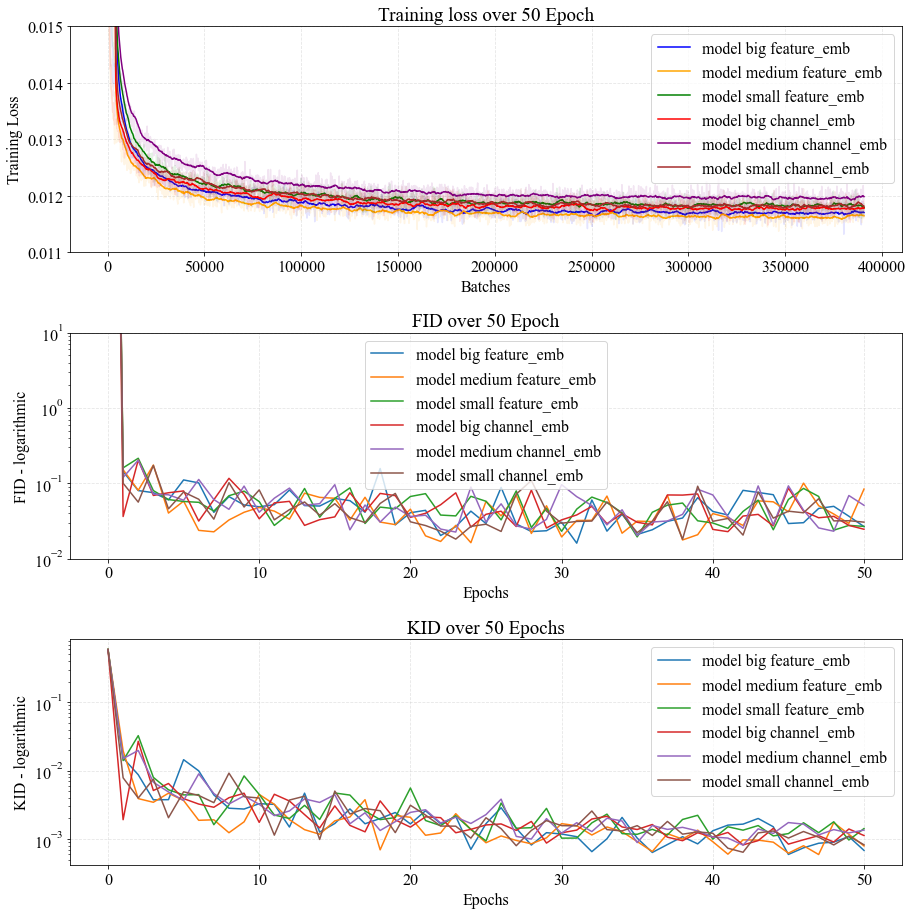

In [96]:
path = "../runs8/"
plt.figure(figsize=(13, 13))
filesLoss = ["lossesmodel_big_featPos.csv", "lossesmodel_big_chanPos.csv", "lossesmodel_med_featPos.csv", "lossesmodel_med_chanPos.csv", "lossesmodel_small_featPos.csv", "lossesmodel_small_chanPos.csv"]
filesFid = ["fidmodel_big_featPos.csv", "fidmodel_big_chanPos.csv", "fidmodel_med_featPos.csv", "fidmodel_med_chanPos.csv", "fidmodel_small_featPos.csv", "fidmodel_small_chanPos.csv"]

modelNamesPlot = ["model big feature_emb", "model medium feature_emb", "model small feature_emb", "model big channel_emb", "model medium channel_emb", "model small channel_emb"]

colorPlot = ["blue", "orange", "green", "red", "purple", "brown"]


plt.subplot(3, 1, 1)
plt.title('Training loss over 50 Epoch')
for i in range(6):
    df = pd.read_csv(path + filesLoss[i])
    plt.plot(df['time'], df['loss'], alpha = 0.1, color = colorPlot[i])
    plt.plot(df['time'], df['loss'].rolling(window=20).mean(), color = colorPlot[i], label=modelNamesPlot[i])
    #plt.fill_between(df['time'][df['loss'].rolling(window=20).mean().dropna().notna()], df['loss'].rolling(window=20).mean().dropna() - df['loss'].rolling(window=20).std().dropna(),  df['loss'].rolling(window=20).mean().dropna() + df['loss'].rolling(window=20).std().dropna(), color = colorPlot[i], alpha = 0.2)
#plt.xscale('log')
plt.ylim(0.011, 0.015)
plt.xlabel('Batches')
plt.ylabel('Training Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('FID over 50 Epoch')
for i in range(6):
    df = pd.read_csv(path + filesFid[i])
    #df = df.iloc[1:]
    plt.plot((df['epoch']), df['fid'], label=modelNamesPlot[i])
plt.ylim(0.01, 10)
plt.yscale('log')
#plt.ylim(1, 100000000)
plt.xlabel('Epochs')
plt.ylabel('FID - logarithmic')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('KID over 50 Epochs')
for i in range(6):
    df = pd.read_csv(path + filesFid[i])
    #df = df.iloc[1:]
    plt.plot((df['epoch']), df['mmd'], label=modelNamesPlot[i])
plt.yscale('log')
#plt.ylim(1000, 10000000000000)
plt.xlabel('Epochs')
plt.ylabel('KID - logarithmic')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#######################################################################
#######################################################################
#######################################################################
#######################################################################
#######################################################################


In [165]:
#######################################################################
# Long Results for 1 Epoch training models 
#######################################################################
for i in range(len(modelList)):
    model = modelList[i]
    model.train(False)
    path = "../runs3/"
    model.load_state_dict(torch.load(path + "model_param_" + modelNames[i] + ".pt", map_location= device))

np.set_printoptions(suppress=True, precision=6)
conf = 5
for i in range(len(modelList)):
    foo = [[0] for _ in range(conf)]
    for j in range(conf):
        fid, kid = validate_model(modelList[i], model_CNN2)
        foo[j] = [fid, kid]
    print(foo)
    print("Mean: ", np.mean(foo, axis=0))
    print("sd: ", np.std(foo, axis=0))
np.set_printoptions(suppress=False)

[[0.16237949756120137, 0.02053701877593994], [0.19723342095604157, 0.025199413299560547], [0.17632276629479812, 0.022344231605529785], [0.1632987900797175, 0.020957469940185547], [0.18367611138583967, 0.022871017456054688]]
Mean:  [0.176582 0.022382]
sd:  [0.013077 0.00165 ]
[[0.2099762255326811, 0.028739452362060547], [0.2087881798364875, 0.02742171287536621], [0.19594642875082577, 0.02644169330596924], [0.2158472173733404, 0.026931047439575195], [0.19375696735440506, 0.028325796127319336]]
Mean:  [0.204863 0.027572]
sd:  [0.008545 0.000853]
[[0.3108760958409854, 0.037178993225097656], [0.3059761652937772, 0.03946352005004883], [0.33094106694633185, 0.04161512851715088], [0.34720312860316205, 0.0500568151473999], [0.31926186227112285, 0.03908264636993408]]
Mean:  [0.322852 0.041479]
sd:  [0.014829 0.004514]
[[0.09582124173540502, 0.01738262176513672], [0.11509828377879786, 0.014498710632324219], [0.11953458254530519, 0.017978429794311523], [0.10886980351639733, 0.01587510108947754], [

In [166]:
#######################################################################
# Long Results for 50 Epoch training models 
#######################################################################
for i in range(len(modelList)):
    model = modelList[i]
    model.train(False)
    path = "../runs4/"
    model.load_state_dict(torch.load(path + "model_param_" + modelNames[i] + ".pt", map_location= device))


np.set_printoptions(suppress=True, precision=6)
conf = 5
for i in range(len(modelList)):
    foo = [[0] for _ in range(conf)]
    for j in range(conf):
        fid, kid = validate_model(modelList[i], model_CNN2)
        foo[j] = [fid, kid]
    print(foo)
    print("Mean: ", np.mean(foo, axis=0))
    print("sd: ", np.std(foo, axis=0))
np.set_printoptions(suppress=False)

[[0.022084648189984957, 0.0009109973907470703], [0.031058809186371654, 0.001120448112487793], [0.04705354066699301, 0.0009397268295288086], [0.05947662815227528, 0.0020540952682495117], [0.03246277191510227, 0.0009056329727172852]]
Mean:  [0.038427 0.001186]
sd:  [0.013225 0.000441]
[[0.03377853028171003, 0.0009549856185913086], [0.04030801401799345, 0.0011324882507324219], [0.03920135854222654, 0.0012203454971313477], [0.038698899728513717, 0.0012235641479492188], [0.027140812122029435, 0.001534581184387207]]
Mean:  [0.035826 0.001213]
sd:  [0.004886 0.000188]
[[0.03983678993054453, 0.002161264419555664], [0.043080133300377785, 0.0012211799621582031], [0.037108323794645424, 0.0016188621520996094], [0.04283750384758468, 0.0009721517562866211], [0.025076455105697403, 0.0009887218475341797]]
Mean:  [0.037588 0.001392]
sd:  [0.006626 0.00045 ]
[[0.04403815905646716, 0.0016698837280273438], [0.02904608824610787, 0.0007911920547485352], [0.04147437888823886, 0.0009806156158447266], [0.05425

In [ ]:
# get CI
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the FID and KID scores
samples = [[0.03983678993054453, 0.002161264419555664], [0.043080133300377785, 0.0012211799621582031], [0.037108323794645424, 0.0016188621520996094], [0.04283750384758468, 0.0009721517562866211], [0.025076455105697403, 0.0009887218475341797]]

fid_scores = np.transpose(samples)[0].tolist()
kid_scores = np.transpose(samples)[1].tolist()

# Set the random seed for reproducibility
np.random.seed(42)

# Number of bootstrap samples
num_samples = 20000

# Perform bootstrap resampling to estimate the confidence intervals
fid_bootstrap_means = []
kid_bootstrap_means = []

for _ in range(num_samples):
    fid_sample = np.random.choice(fid_scores, size=len(fid_scores), replace=True)
    kid_sample = np.random.choice(kid_scores, size=len(kid_scores), replace=True)
    fid_bootstrap_means.append(np.mean(fid_sample))
    kid_bootstrap_means.append(np.mean(kid_sample))
    
np.set_printoptions(suppress=True, precision=4)
print(1.96 * np.std(fid_bootstrap_means))
print(1.96 * np.std(kid_bootstrap_means))
print("{:.4f}".format(1.96 * np.std(fid_bootstrap_means)))
print("{:.4f}".format(1.96 * np.std(kid_bootstrap_means)))

In [ ]:
#######################################################################
#######################################################################
#######################################################################
#######################################################################
#######################################################################

No handles with labels found to put in legend.


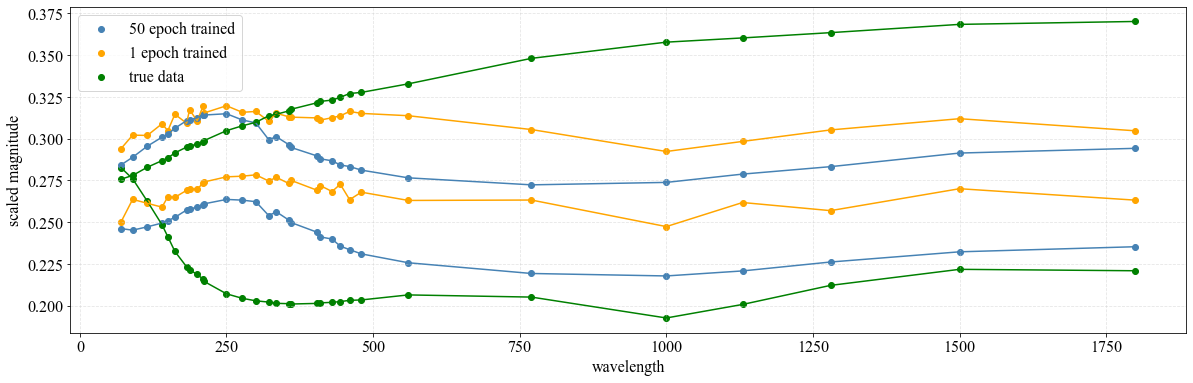

In [40]:
for i in range(len(modelList)):
    model = modelList[i]
    model.train(False)
    path = "../runs4/"
    model.load_state_dict(torch.load(path + "model_param_" + modelNames[i] + ".pt", map_location= device))


sample1 = (denoise(modelList[5], 2).cpu().detach()).squeeze()


for i in range(len(modelList)):
    model = modelList[i]
    model.train(False)
    path = "../runs3/"
    model.load_state_dict(torch.load(path + "model_param_" + modelNames[i] + ".pt", map_location= device))

sample2 = (denoise(modelList[5], 2).cpu().detach()).squeeze()

colors = ["steelblue", "orange", "green"]
plt.figure(figsize= (20, 6))
for i in range(2):
    if i == 1:
        plt.scatter(filter_wls, sample1[i].numpy(), label = "50 epoch trained", color = colors[0])
        plt.plot(filter_wls, sample1[i].numpy(), color = colors[0])
        plt.scatter(filter_wls, sample2[i].numpy(), label = "1 epoch trained", color = colors[1])
        plt.plot(filter_wls, sample2[i].numpy(), color = colors[1])
        r = np.random.randint(1, 10000)
        plt.scatter(filter_wls, vX_scaled[r], label = "true data", color = colors[2])
        plt.plot(filter_wls, vX_scaled[r], color = colors[2])
        plt.xlabel("wavelength")
        plt.ylabel("scaled magnitude")
        plt.legend()
        continue
    plt.scatter(filter_wls, sample1[i].numpy(), color = colors[0])
    plt.plot(filter_wls, sample1[i].numpy(), color = colors[0])
    plt.scatter(filter_wls, sample2[i].numpy(), color = colors[1])
    plt.plot(filter_wls, sample2[i].numpy(), color = colors[1])
    r = np.random.randint(1, 100000)
    plt.scatter(filter_wls, vX_scaled[r], color = colors[2])
    plt.plot(filter_wls, vX_scaled[r], color = colors[2])
    plt.xlabel("wavelength")
    plt.ylabel("scaled magnitude")
    plt.legend()
plt.show()


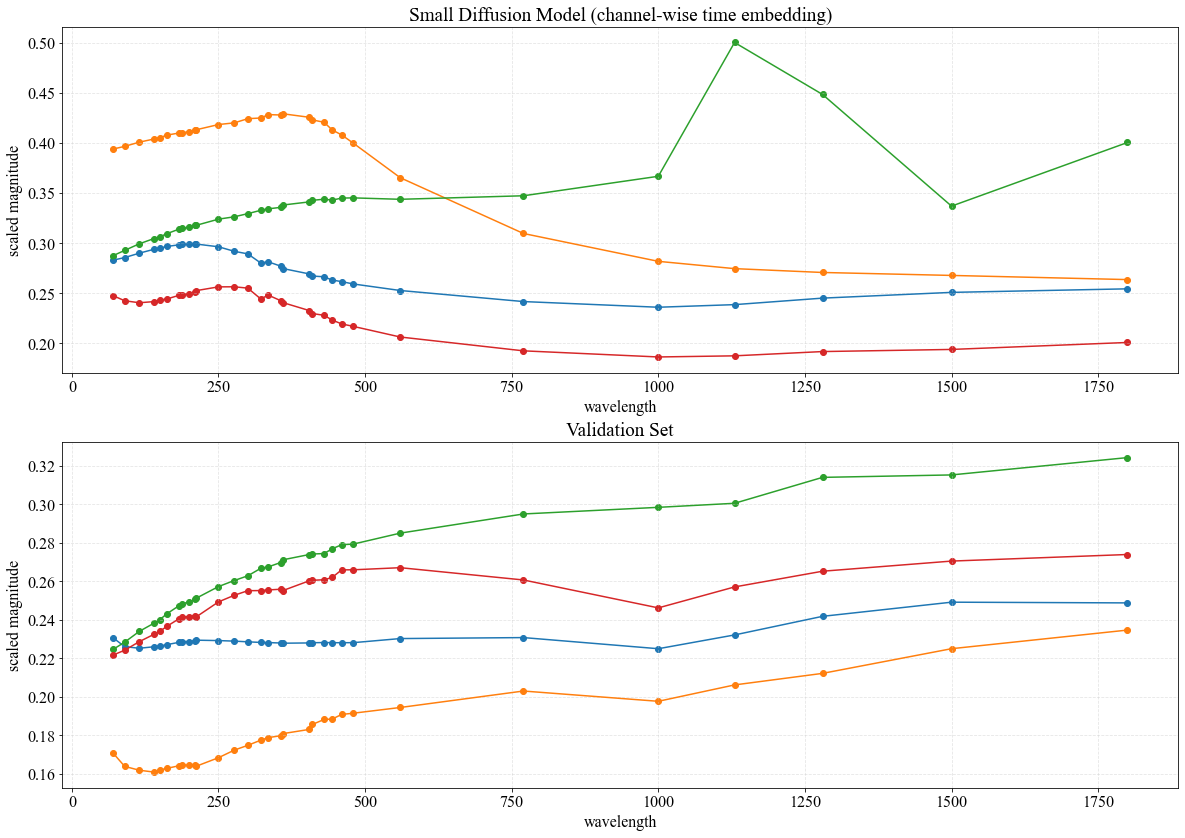

In [16]:
for i in range(len(modelList)):
    model = modelList[i]
    model.train(False)
    path = "../runs4/"
    model.load_state_dict(torch.load(path + "model_param_" + modelNames[i] + ".pt", map_location= device))

plt.figure(figsize= (20, 14))

sample6 = (denoise(modelList[5], 4).cpu().detach()).squeeze()

for i in range(4):
    plt.subplot(2, 1, 1)
    plt.title('Small Diffusion Model (channel-wise time embedding)')
    plt.scatter(filter_wls, sample6[i].numpy())
    plt.plot(filter_wls, sample6[i].numpy())
    #plt.legend()
    plt.xlabel("wavelength")
    plt.ylabel("scaled magnitude")

    plt.subplot(2, 1, 2)
    plt.title('Validation Set')
    r = np.random.randint(1, 10000)
    plt.scatter(filter_wls, vX_scaled[r])
    plt.plot(filter_wls, vX_scaled[r])
    #plt.legend()
    plt.xlabel("wavelength")
    plt.ylabel("scaled magnitude")

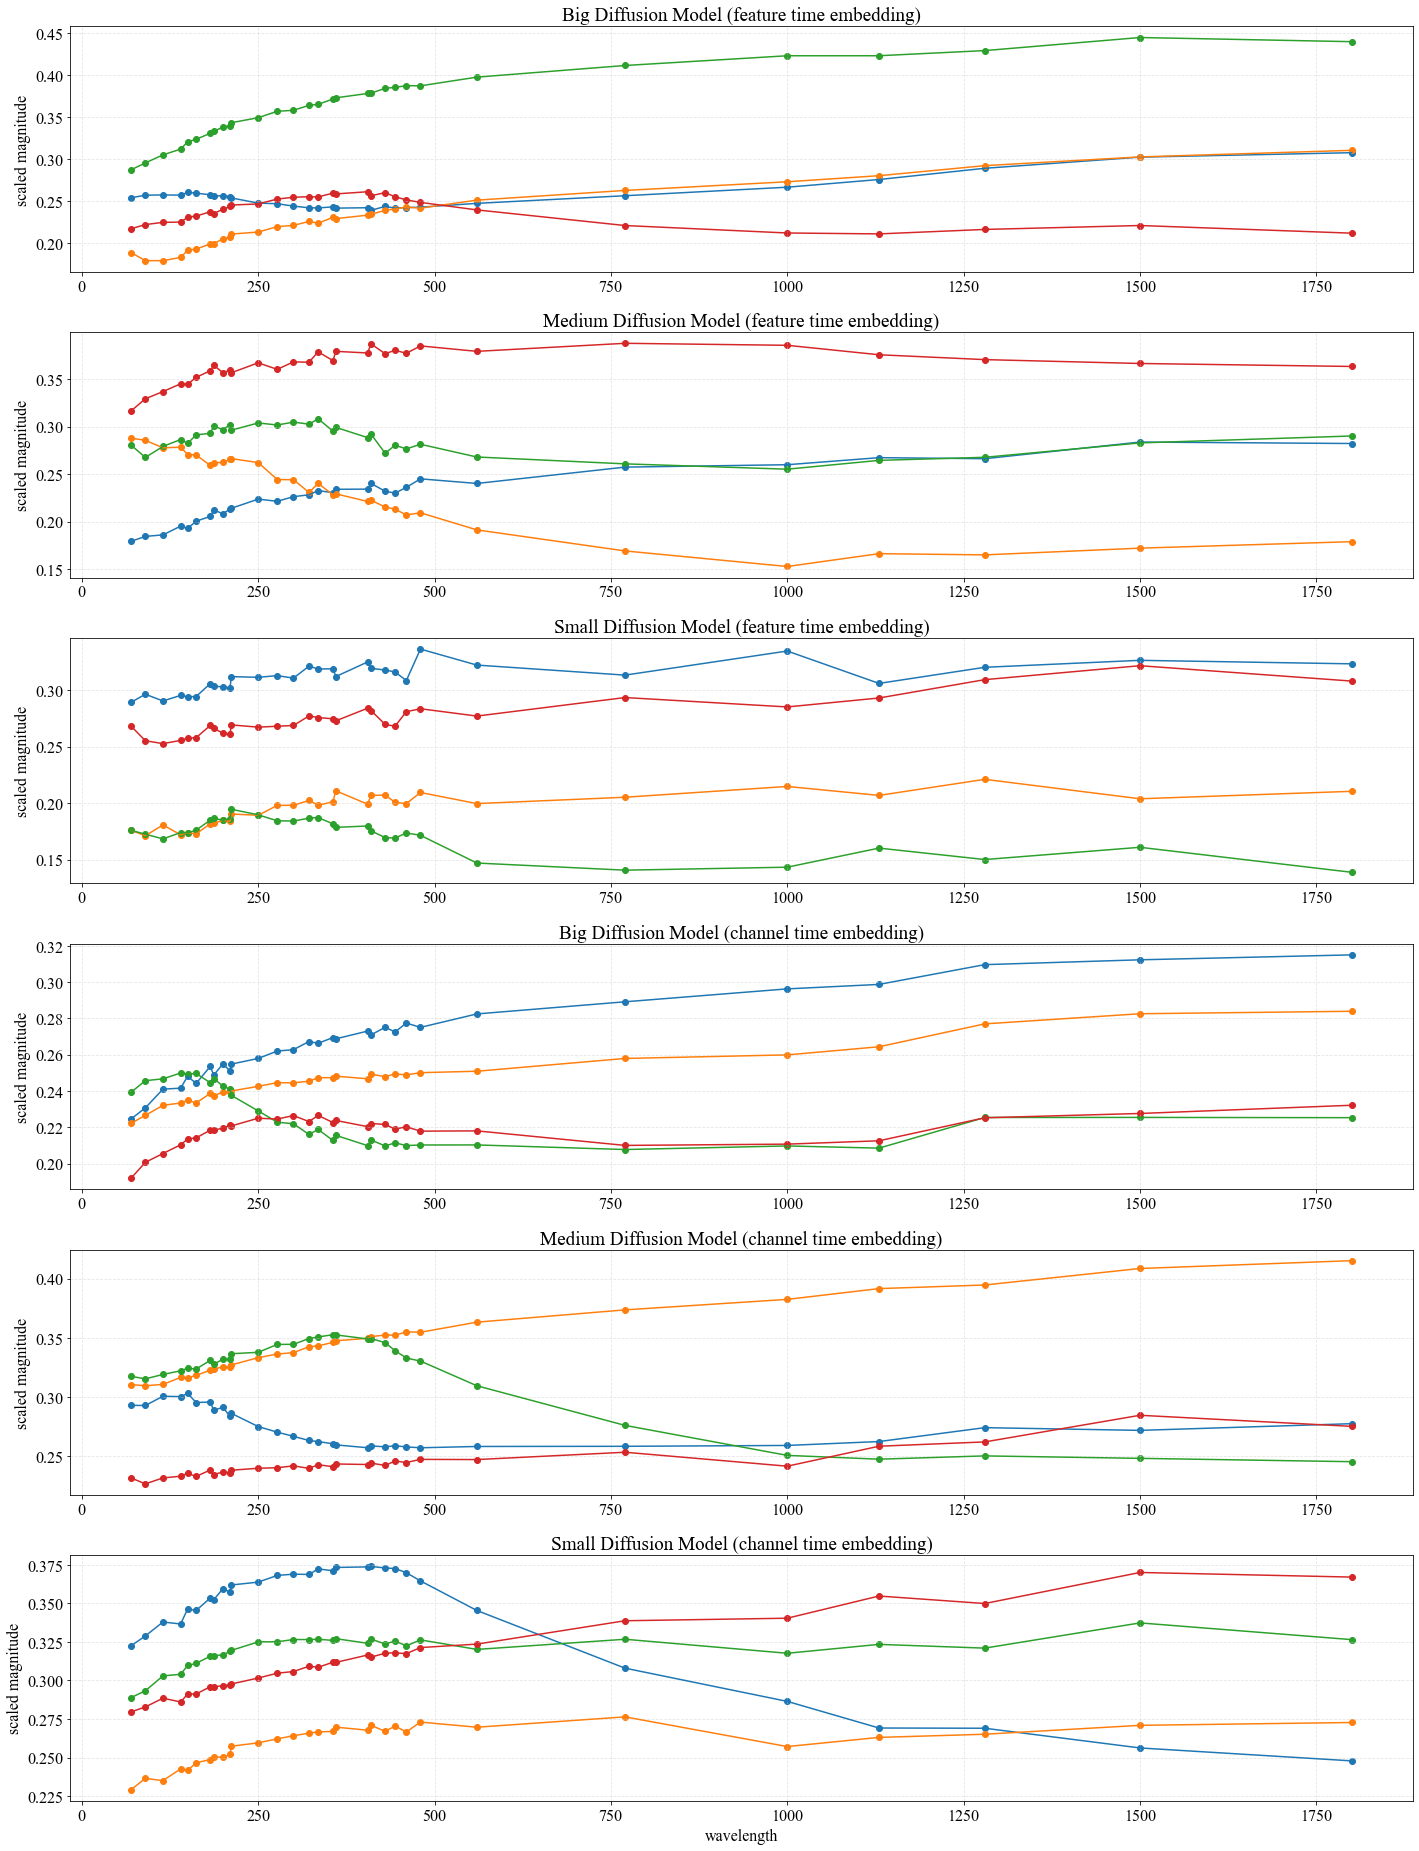

In [14]:
for i in range(len(modelList)):
    model = modelList[i]
    model.train(False)
    path = "../runs3/"
    model.load_state_dict(torch.load(path + "model_param_" + modelNames[i] + ".pt", map_location= device))

plt.figure(figsize= (20, 26))

sample1 = (denoise(modelList[0], 4).cpu().detach()).squeeze()
sample2 = (denoise(modelList[1], 4).cpu().detach()).squeeze()
sample3 = (denoise(modelList[2], 4).cpu().detach()).squeeze()
sample4 = (denoise(modelList[3], 4).cpu().detach()).squeeze()
sample5 = (denoise(modelList[4], 4).cpu().detach()).squeeze()
sample6 = (denoise(modelList[5], 4).cpu().detach()).squeeze()

for i in range(4):
    plt.subplot(6, 1, 1)
    plt.title('Big Diffusion Model (feature time embedding)')
    plt.scatter(filter_wls, sample1[i].numpy())
    plt.plot(filter_wls, sample1[i].numpy())
    #plt.legend()
    #plt.xlabel("wavelength")
    plt.ylabel("scaled magnitude")

    plt.subplot(6, 1, 2)
    plt.title('Medium Diffusion Model (feature time embedding)')
    r = np.random.randint(0, 100000)
    plt.scatter(filter_wls, sample2[i].numpy())
    plt.plot(filter_wls, sample2[i].numpy())
    plt.ylabel("scaled magnitude")
    #plt.ylim(-2, 2)
    #plt.legend()

    plt.subplot(6, 1, 3)
    plt.title('Small Diffusion Model (feature time embedding)')
    plt.scatter(filter_wls, sample3[i].numpy())
    plt.plot(filter_wls, sample3[i].numpy())
    plt.ylabel("scaled magnitude")
    #plt.ylim(-2, 2)
    #plt.legend()

    plt.subplot(6, 1, 4)
    plt.title('Big Diffusion Model (channel time embedding)')
    plt.scatter(filter_wls, sample4[i].numpy())
    plt.plot(filter_wls, sample4[i].numpy())
    plt.ylabel("scaled magnitude")
    #plt.ylim(-2, 2)
    #plt.legend()

    plt.subplot(6, 1, 5)
    plt.title('Medium Diffusion Model (channel time embedding)')
    plt.scatter(filter_wls, sample5[i].numpy())
    plt.plot(filter_wls, sample5[i].numpy())
    plt.ylabel("scaled magnitude")
    #plt.ylim(-2, 2)
    #plt.legend()

    plt.subplot(6, 1, 6)
    plt.title('Small Diffusion Model (channel time embedding)')
    plt.scatter(filter_wls, sample6[i].numpy())
    plt.plot(filter_wls, sample6[i].numpy())
    plt.ylabel("scaled magnitude")
    #plt.ylim(-2, 2)
    plt.xlabel("wavelength")
    #plt.legend()
    
plt.tight_layout()
plt.show()

In [123]:
#targets = denoise(modelList[0], 4).squeeze().detach().cpu()
targets = sample1

extended_big_tensor = torch.tensor(vX_scaled).unsqueeze(0).expand(targets.shape[0], -1, -1)

extended_small_tensors = targets.unsqueeze(1).expand(-1, torch.tensor(vX_scaled).shape[0], -1)

mse_tensor = F.mse_loss(extended_big_tensor, extended_small_tensors, reduction='none').mean(dim=2)

min_mse_indices = mse_tensor.argmin(dim=1)
print(torch.min(mse_tensor[0]))

closest_tensors = torch.tensor(vX_scaled)[min_mse_indices]

tensor(3.2213e-06)


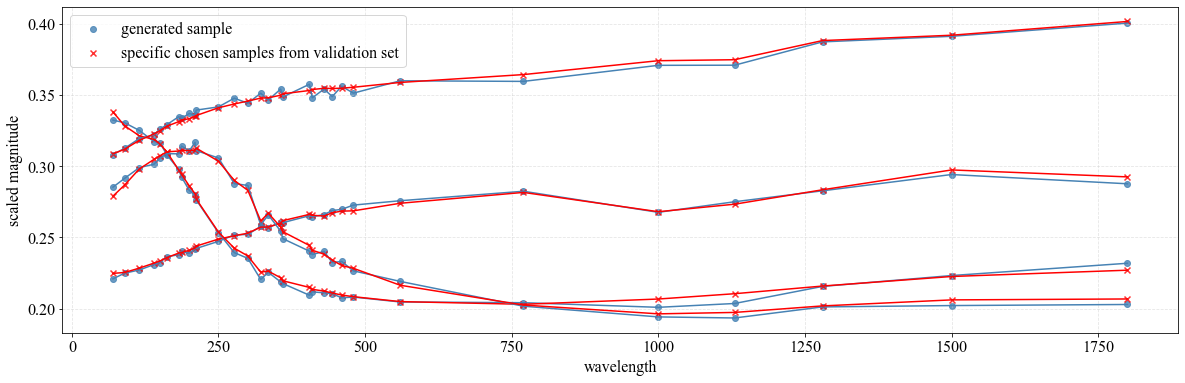

In [124]:

plt.figure(figsize= (20, 6))

colors = ["steelblue", "red", "orange", "green"]


for i in range(len(closest_tensors)):
    if i == 0:
        label_0 = "generated sample"
        label_1 = "specific chosen samples from validation set"
    else:
        label_0 = None
        label_1 = None
    plt.subplot(1, 1, 1)
    #plt.title('MSE close generated samples', fontsize = 20)
    plt.scatter(filter_wls, targets[i].numpy(), label = label_0, color = colors[0], alpha = 0.8, marker = 'o')
    plt.plot(filter_wls, targets[i].numpy(), color = colors[0], alpha = 1)
    plt.scatter(filter_wls, closest_tensors[i].numpy(), label = label_1, color = colors[1], alpha = 0.8, marker = 'x')
    plt.plot(filter_wls, closest_tensors[i].numpy(), color = colors[1], alpha = 1)

plt.ylabel("scaled magnitude")
#plt.ylim(-2, 2)
plt.xlabel("wavelength")
plt.legend()

Evaluation

In [ ]:
############################################################################
# evaluation model training
############################################################################


In [75]:
def train_modelCNN(model, n = len(X_normalized), batch_size = 256, EPOCHS = 50):
    #loss
    loss_fn = nn.MSELoss()
    #optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    #loss data
    running_loss_arr = []

    #training
    model.train(True)
    with open(path + "foo.txt", "w") as f:
        f.write("start \n")
    for epoch in range(EPOCHS):
        with open(path + "foo.txt", "a") as f:
            f.write("epoch: " + str(epoch) + "\n")
        # generate data_loader
        train_dataloader = DataLoader(MyDataset({"X": X_scaled[:n], "y": y_normalized[:n]}), batch_size=batch_size, shuffle=True)
        
        print('EPOCH ', epoch, ":")
        
        running_loss = 0
        last_loss = 0

        for i, data in enumerate(train_dataloader):
            X_t = data['X'].unsqueeze(1).to(device)
            ys = data['y'].unsqueeze(1).to(device)
            # Zero gradients for every batch
            optimizer.zero_grad()


            # Make predictions for this batch
            _, outputs = model(X_t)

            # Compute the loss and its gradients
            loss = loss_fn(outputs, ys.squeeze())

            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                last_loss = running_loss / 100 # loss per batch
                tb_x = epoch * len(train_dataloader) + i + 1
                running_loss_arr.append([tb_x, last_loss])
                running_loss = 0.
                with open(path + "foo.txt", "a") as f:
                    f.write(str(last_loss) + "\n")
        scheduler.step()

        print('LOSS train: ', running_loss_arr[-1])

    model.train(False)
    return np.array(running_loss_arr)


In [96]:
# train all models
T = 1000
n = len(X_scaled)
batch_size = 256
epochs = 30
path = "../runsCNN2/"
model_CNN = CNN().to(device)
name = "model_CNN"

print("#####################################")
print("n: ", n)
print("batch_size: ", batch_size)
print("Epochs: ", epochs)
#print("model: ", model)

running_loss_arr = train_modelCNN(model_CNN, n = n, batch_size = batch_size, EPOCHS = epochs)

torch.save(model_CNN.state_dict(), path + "model_param_" + name + ".pt")
df_loss = pd.DataFrame({"time": running_loss_arr.reshape(-1, 2).transpose()[0], "loss": running_loss_arr.reshape(-1, 2).transpose()[1]})
df_loss.to_csv(path + "losses" + name + ".csv", index = False)


print("#####################################")

#####################################
n:  4000000
batch_size:  256
Epochs:  30
EPOCH  0 :
LOSS train:  [15600, 0.3050747463107109]
EPOCH  1 :
LOSS train:  [31225, 0.2659891848266125]
EPOCH  2 :
LOSS train:  [46850, 0.24941833674907685]
EPOCH  3 :
LOSS train:  [62475, 0.24172014459967614]
EPOCH  4 :
LOSS train:  [78100, 0.23267146050930024]
EPOCH  5 :
LOSS train:  [93725, 0.22991128042340278]
EPOCH  6 :
LOSS train:  [109350, 0.22132403954863547]
EPOCH  7 :
LOSS train:  [124975, 0.21717177972197532]
EPOCH  8 :
LOSS train:  [140600, 0.21553953796625136]
EPOCH  9 :
LOSS train:  [156225, 0.21375473499298095]
EPOCH  10 :
LOSS train:  [171850, 0.21171192079782486]
EPOCH  11 :
LOSS train:  [187475, 0.2093116158246994]
EPOCH  12 :
LOSS train:  [203100, 0.20706234261393547]
EPOCH  13 :
LOSS train:  [218725, 0.20808968871831893]
EPOCH  14 :
LOSS train:  [234350, 0.20405543431639672]
EPOCH  15 :
LOSS train:  [249975, 0.20608785420656203]
EPOCH  16 :
LOSS train:  [265600, 0.20488330066204072]
EPOCH